In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses
import matplotlib.pyplot as plt

## Load the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


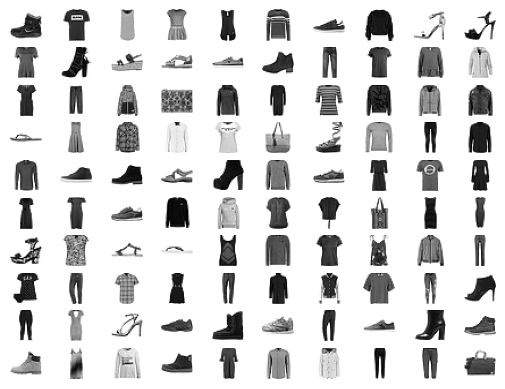

In [3]:
for i in range(10*10):
  plt.subplot(10, 10, 1 + i)
  plt.axis('off')
  plt.imshow(x_train[i], cmap='gray_r')
plt.show()

# Unconditional GAN

## Discriminator

In [4]:
def define_discriminator(in_shape=(28, 28, 1)):
  model = keras.Sequential()
  model.add(layers.Conv2D(128, (3, 3), strides=2, padding='same', input_shape=in_shape))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=["accuracy"])
  return model

discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6

## Generator

In [5]:
def define_generator(latent_dim):
  model = keras.Sequential()
  n_nodes = 128 * 7 * 7
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Reshape((7, 7, 128)))
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2D(1, (7, 7), activation='tanh', padding='same'))
  return model

generator = define_generator(100)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

## GAN

In [6]:
def define_gan(generator, discriminator):
  discriminator.trainable = False
  model = keras.Sequential()
  model.add(generator)
  model.add(discriminator)
  model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
  return model

gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential (Sequential)     (None, 1)                 155137    
                                                                 
Total params: 1,319,426
Trainable params: 1,164,289
Non-trainable params: 155,137
_________________________________________________________________


## Utility Functions

In [7]:
def load_real_samples():
  (x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()
  x = np.expand_dims(x_train, axis=-1)
  x = (x - 127.5) / 127.5
  return x

def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  x = dataset[ix]
  y = np.ones((n_samples, 1))
  return x, y

def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  x = generator.predict(x_input)
  y = np.zeros((n_samples, 1))
  return x, y

## Train the GAN

In [8]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(x_real, y_real)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print('>%d, %d%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  g_model.save('generator.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim)

2/2 [==============================] - 0s 8ms/step
>1, 1468, d1=0.677, d2=0.695 g=0.691
2/2 [==============================] - 0s 4ms/step
>1, 2468, d1=0.599, d2=0.699 g=0.688
2/2 [==============================] - 0s 6ms/step
>1, 3468, d1=0.552, d2=0.706 g=0.682
2/2 [==============================] - 0s 5ms/step
>1, 4468, d1=0.486, d2=0.717 g=0.670
2/2 [==============================] - 0s 6ms/step
>1, 5468, d1=0.442, d2=0.737 g=0.656
2/2 [==============================] - 0s 6ms/step
>1, 6468, d1=0.395, d2=0.758 g=0.637
2/2 [==============================] - 0s 5ms/step
>1, 7468, d1=0.355, d2=0.789 g=0.616
2/2 [==============================] - 0s 6ms/step
>1, 8468, d1=0.320, d2=0.820 g=0.606
2/2 [==============================] - 0s 5ms/step
>1, 9468, d1=0.290, d2=0.832 g=0.610
2/2 [==============================] - 0s 6ms/step
>1, 10468, d1=0.294, d2=0.808 g=0.643
2/2 [==============================] - 0s 5ms/step
>1, 11468, d1=0.258, d2=0.758 g=0.702
2/2 [=========================

## Generating New Images

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_sampels)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

def show_pint(examples, n):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

model = keras.models.load_models('generator.h5')
latent_points = generate_latent_points(100, 100)
x = model.predict(latent_points)
show_plot(x, 10)